In [ ]:
# 파이토치

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import argparse
import time
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class View(nn.Module):

    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape) # x.shape == (batch_size, channel, width, height)

class Inception_module(nn.Module):

    def __init__(self, in_ch, out_ch):

        super(Inception_module, self).__init__()

        branch1 = []
        branch1 += [nn.Conv2d(in_ch, out_ch, kernel_size=1),
                    nn.ReLU(inplace=True)]

        branch2 = []
        branch2 += [nn.Conv2d(in_ch, out_ch, kernel_size=1),
                    nn.ReLU(True),
                    nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                    nn.ReLU(True)]

        branch3 = []
        branch3 += [nn.Conv2d(in_ch, out_ch, kernel_size=1),
                    nn.ReLU(True),
                    nn.Conv2d(out_ch, out_ch, kernel_size=5, padding=2),
                    nn.ReLU(True)]

        branch4 = []
        branch4 += [nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_ch, out_ch, kernel_size=1)]

        self.layer1 = nn.Sequential(*branch1)
        self.layer2 = nn.Sequential(*branch2)
        self.layer3 = nn.Sequential(*branch3)
        self.layer4 = nn.Sequential(*branch4)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x)
        x4 = self.layer4(x)

        out = torch.cat((x1, x2, x3, x4), dim=1)    # (batchsize, channel, width, height)
        return out


class GoogleNet(nn.Module):

    def __init__(self):
        super(GoogleNet, self).__init__()

        layer = []
        layer += [nn.Conv2d(in_channels=1, out_channels=64, stride=2, kernel_size=7, padding=3, bias=False), # 64 x 14 x 14
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False), # 192 x 14 x 14
                  nn.BatchNorm2d(192),
                  nn.ReLU(inplace=True),
                  Inception_module(192, 256),
                  Inception_module(256*4, 480), # concat되면서 input 채널 수가 4배가 됨
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 480 x 7 x 7
                  Inception_module(480*4, 512),
                  Inception_module(512*4, 512)] # 512 x 7 x 7

        get_aux1 = []
        get_aux1 += [View(-1),
                     nn.Linear(100352, 512),
                     nn.ReLU(True),
                     nn.Linear(512, 10)]

        layer2 = []
        layer2 += [Inception_module(512*4, 512), # 나온 output 채널 개수가 512이고 인셉션에서 4배
                   Inception_module(512*4, 528),
                   Inception_module(528*4, 832)]

        get_aux2 = []
        get_aux2 += [View(-1),
                     nn.Linear(163072, 832),
                     nn.ReLU(True),
                     nn.Linear(832, 10)]

        layer3 = []
        layer3 += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                   Inception_module(832*4, 832),
                   Inception_module(832*4, 1024),
                   nn.AdaptiveAvgPool2d((1,1)),
                   View(-1),
                   nn.Dropout(0.4),
                   nn.Linear(4096, 10)]
        self.layer = nn.Sequential(*layer)
        self.layer2 = nn.Sequential(*layer2)
        self.layer3 = nn.Sequential(*layer3)
        self.get_aux1 = nn.Sequential(*get_aux1)
        self.get_aux2 = nn.Sequential(*get_aux2)


    def forward(self, x):
        x = self.layer(x)
        aux1 = self.get_aux1(x)
        x = self.layer2(x)
        aux2 = self.get_aux2(x)
        x = self.layer3(x)

        return x, aux1, aux2

if __name__ == '__main__':

    from torchsummary import summary
    model = GoogleNet()
    summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 192, 14, 14]         110,592
       BatchNorm2d-5          [-1, 192, 14, 14]             384
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 256, 14, 14]          49,408
              ReLU-8          [-1, 256, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]          49,408
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
             ReLU-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 256, 14, 14]          49,408
             ReLU-14          [-1, 256,

In [ ]:
# MNIST 데이터에 대해서 훈련 및 검증

# initial parameters

seed = 6 # weight 초깃값 설정: 이렇게 설정해주면 돌릴때마다 weight 안변함
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 256
args.model = GoogleNet()
args.loss_fn1 = nn.CrossEntropyLoss()
args.loss_fn2 = nn.CrossEntropyLoss()
args.loss_fn3 = nn.CrossEntropyLoss()
args.batch_size = 1024
args.lr = 0.01
args.epoch = 5

# 데이터 준비

train_datasets = MNIST(root='./datasets', train=True, transform=ToTensor(), download=True)
validation_datasets = MNIST(root='./datasets', train=False, transform=ToTensor(), download=True)

def acc(y_pred, y_true, batch_size):
    accuracy = torch.sum(torch.eq(torch.argmax(y_pred, dim=1), y_true)).item() / batch_size * 100 
    return accuracy

def train(model, datasets, optimizer, loss_fn, args):
    trainloader = DataLoader(dataset=datasets,
                             batch_size=args.batch_size,
                             shuffle=True,
                             drop_last=True) # drop_last: 데이터는 6만개인데 배치사이즈가 256이면 딱 안나눠지니까 나머지는 떨구는 것
    model.train() # 이번 모델은 train에 쓰겠다
    model.zero_grad()
    optimizer.zero_grad()
    
    loss_fn = args.loss_fn # loss function은 어쨌든 모두 같은 crossentropy를 써야 하므로 똑같은 걸로.
    loss_fn2 = args.loss_fn
    loss_fn3 = args.loss_fn

    train_acc = 0.0

    for i, (X, y) in enumerate (trainloader): # 데이터를 만들어주는 것
        X = X.to(args.device)
        y_true = y.to(args.device)
        y1, y2, y3 = model(X) 
        # 한편 loss function을 통해 각각 가중치가 업데이트 되야하므로 각각의 loss function을 정의해줘야 한다. (밑에)
        loss = loss_fn(y1, y_true) + (0.3*loss_fn2(y2, y_true)) + (0.3*loss_fn3(y3, y_true))
        accuracy = acc(y_pred=y1, y_true= y_true, batch_size=args.batch_size)

        model.zero_grad() # 초기화하라
        optimizer.zero_grad() # 초기화하라
        loss.backward() # 로스 (오류) 역전파해라
        optimizer.step() # 옵티마이저는 가중치를 갱신하라

        train_acc += accuracy

    train_acc = train_acc / len(trainloader)

    return train_acc

def validate(model, datasets, args):
    valloader = DataLoader(dataset=datasets,
                             batch_size=args.batch_size,
                             shuffle=False,
                             drop_last=True)
    model.eval() # 이번 모델은 val에 쓰겠다

    val_acc = 0.0
    
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.to(args.device)
            y_true = y.to(args.device)
            y_pred = model(X)

            accuracy = acc(y_pred=y_pred, y_true=y_true, batch_size=args.batch_size)
            val_acc += accuracy

    val_acc = val_acc / len(valloader)

    return val_acc

def training(train_datasets, val_datasets, args):
    model = args.model
    model.to(args.device)

    print('Device : ', args.device)

    loss_fn = args.loss_fn
    optimizer = optim.SGD(model.parameters(), lr=args.lr) # 모델의 parameter들과 learnig rate를 참고해라

    epoch_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(args.epoch):
        ts = time.time()

        train_acc = train(model=model, datasets=train_datasets, optimizer=optimizer, loss_fn=loss_fn, args=args)
        val_acc = validate(model=model, datasets=val_datasets, args=args)

        te = time.time()

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        epoch_list.append(epoch)
        print('Epoch {}, acc(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch,train_acc,val_acc,te - ts))
                                                                                
    plt.title('GoogleNet')
    plt.plot(epoch_list, train_acc_list)
    plt.plot(epoch_list, val_acc_list)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.show()

    torch.save(model.state_dict(), 'GoogleNet.pt') # 모델의 가중치 상태를 dict형태로 저장

training(train_datasets, validation_datasets, deepcopy(args))

# model = GoogleNet()
# model.load_stat_dict(torch.load('CNN.pt'))를 쓰면 원래 사용하던 모델을 불러와서 이어서 쓸 수 있다

In [2]:
# 케라스

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Dense, Dropout, AveragePooling2D, concatenate, Flatten
from keras.models import Model
from keras import models

Using TensorFlow backend.


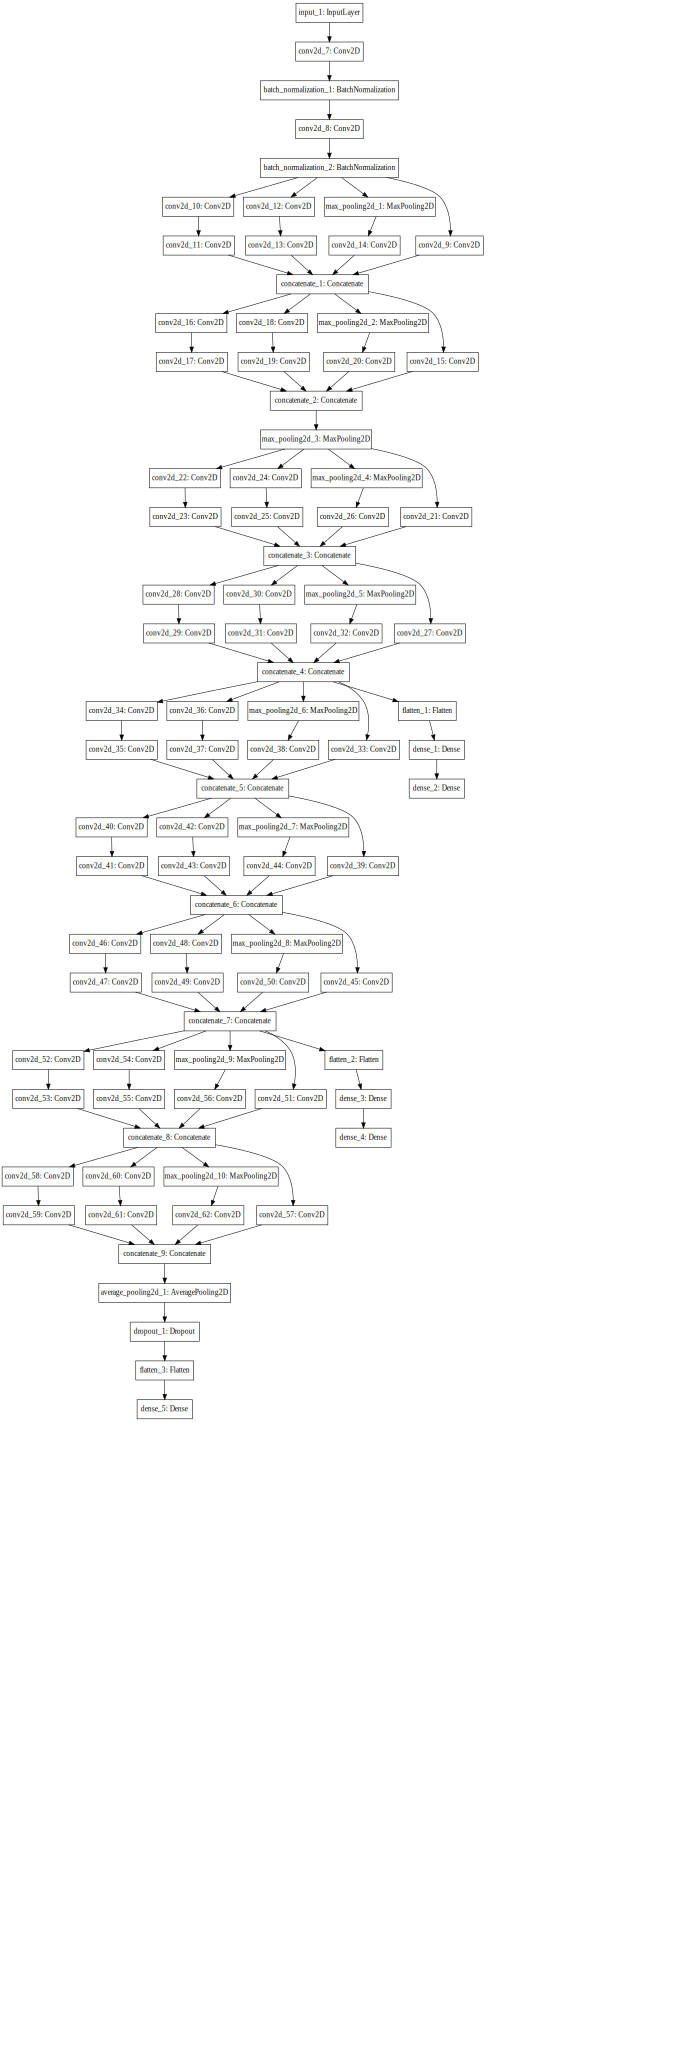

In [9]:
def inception(x, ch_num): # Conv2D의 ch_num은 output의 channel 갯수
    pre_layer = x
    conv1 = Conv2D(ch_num, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(ch_num, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(ch_num, kernel_size=(3,3), padding='same', activation='relu')(conv2)
    conv3 = Conv2D(ch_num, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(ch_num, kernel_size=(5,5), padding='same', activation='relu')(conv3)
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(ch_num, kernel_size=(1,1), padding='same')(max_pool)
    
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1)
    # output = [None(batch_size), w,h,c] 인데 c 기준으로 concatenate 시키므로 axis는 마지막 c인 -1
    
    return concat
    
    
inputs = Input(shape=(28,28,1))

# 원래 conv랑 batch 사이에 max pooling 들어가는데 mnist 데이터에선 그렇게 하면 크기 너무 줄어들어서 그냥 뺐음
x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu', use_bias=False)(x)
x = BatchNormalization()(x) 
# BatchNormalization이 데아터의 분포 곡선 모양을 다른 데이터의 그것과 똑같이 하고, 위치를 똑같이 조정시켜주는 것인데  
# 위치 조정을 하는것, 즉 Conv2D에서 use_bias의 기본값이 True이므로 BatchNormalization을 하기 전에는 굳이 use_bias를 True로 하지 않는다

x = inception(x,256)
x = inception(x,480)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

x = inception(x,512)
x = inception(x,512)

aux1 = Flatten()(x)
aux1 = Dense(512, activation='relu')(aux1)
aux1 = Dense(10, activation='softmax')(aux1)

x = inception(x,512)
x = inception(x,528)
x = inception(x,832)

aux2 = Flatten()(x)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(10, activation='softmax')(aux2)

x = inception(x,832)
x = inception(x,1024)
x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', loss_weights=[0.3,0.3,1.0]) 
# outputs에다가 가중치를 loss_weights=[0.3,0.3,1.0]만큼 준다

# 모델 그림 보기

from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, dpi=50).create(prog='dot', format='svg'))

In [12]:
# mnist 데이터 준비

import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

width = 28
height = 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, width, height, 1).astype('float32')/255.0
x_test = x_test.reshape(10000, width, height, 1).astype('float32')/255.0

num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
# 모델 훈련

model.fit(x_train, [y_train], batch_size=256, epochs=10, verbose = 2, validation_split=0.1)
score = model.evaluate(x_test, y_test) # [loss, acc]

print('loss: ', score[0])
print('acc: ', score[1])